In [1]:
import fastai.data.all as fai_data
import fastai.vision.all as fai_vision
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
path = fai_data.untar_data(fai_data.URLs.MNIST)
path

Path('/home/daynil/.fastai/data/mnist_png')

In [4]:
dls = fai_vision.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_vision.MultiCategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_vision.GrandparentSplitter('training', 'testing'),
    get_y=fai_vision.parent_label
).dataloaders(path)

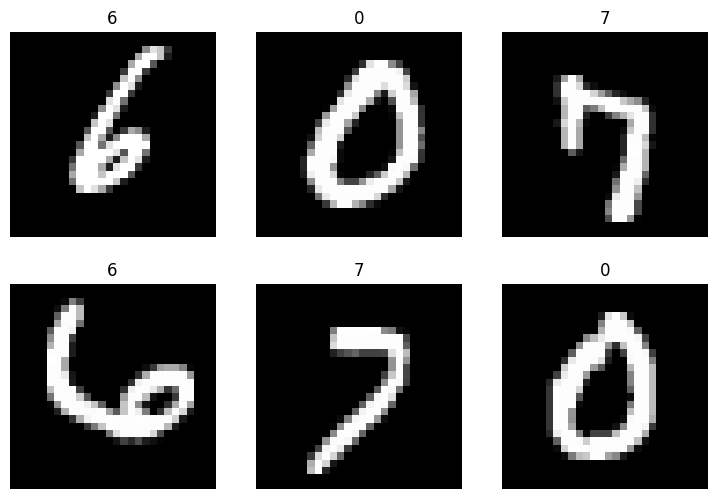

In [5]:
dls.show_batch(max_n=6)

In [139]:
images, labels = dls.train.one_batch()
# We have a batch of 64 images, with an RGB stack (3) of 28x28 pixels
images.shape

torch.Size([64, 3, 28, 28])

TensorMultiCategory(4, device='cuda:0')


<Axes: >

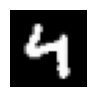

In [140]:
one_image = images[0]
print(labels[0].argmax())
one_image.show()

For the purposes of our pure python learner version, we want to compress the RGB image to grayscale, then combine all of the pixel rows into 1 row. This way, we can assign a weight to each pixel.

In [141]:
gray_image = torchvision.transforms.functional.rgb_to_grayscale(one_image)
gray_image_squeezed = gray_image.squeeze()
gray_image_squeezed_flattened = gray_image_squeezed.flatten()
one_image.shape, gray_image.shape, gray_image_squeezed.shape, gray_image_squeezed_flattened.shape

(torch.Size([3, 28, 28]),
 torch.Size([1, 28, 28]),
 torch.Size([28, 28]),
 torch.Size([784]))

In [142]:
# Pixels per dimension
px_per_dim = 28
images_tfmd = (
    torchvision.transforms.functional
        .rgb_to_grayscale(images).squeeze().view(64, px_per_dim**2)
)
images_tfmd.shape

torch.Size([64, 784])

In [6]:
# Pixels per dimension
px_per_dim = 28
torch.random.manual_seed(42)

To create a simple 1-layer neural network, we need to initialize the parameters in a particular way.

First, we need a weight for each pixel in the image, so 28*28 (784) weights, as well as a bias. This produces the parameters for a single neuron.

One neuron won't be enough to do anything useful, so we create this set of parameters for the amount of neurons we want, in this case, 100. Effectively, we get a set of 784 weights and 1 bias for each of the 100 neurons.

We represent this with tensors by creating a weights tensor and a bias tensor. The weights tensor is (pixels, hidden_neurons), and the bias is just hidden_neurons.

In [7]:
hidden_neurons = 100
# There are a total of 10 number classes (digits 0-9)
mnist_classes = 10

weights_layer_1 = torch.randn((px_per_dim**2, hidden_neurons), requires_grad=True, device=device)
bias_layer_1 = torch.randn(hidden_neurons, requires_grad=True, device=device)

weights_layer_2 = torch.randn((hidden_neurons, mnist_classes), requires_grad=True, device=device)
bias_layer_2 = torch.randn(mnist_classes, requires_grad=True, device=device)

Breaking down each of the model's forward pass, we have:

First linear layer:
Matrix multiply a batch of images by its weights and add the biases:
$$y = wx + b$$

This gives us a single output, y, for each neuron, so we have **100 total outputs per image**.

It's hard to associate this linear equation properly *per image* because matrix multiplication involves two "layers" of data - a `batch` of `batch_size` images as well as a set of weights of length `px` (pixels per image). If we apply the equation above to a single image, we get:

$$y = w_{px}x_{px} + b$$

This means we're matrix multiplying each individual pixel in the image by a weight for that image, then adding a bias. So here, y is the result for a single image, for a single neuron.

However, in practice, we never use a single data item in our matrix multiplication because the GPU needs to have enough data to process for it to be efficient. Likewise, we also usually have more than one neuron in a given layer.

In [8]:
res = images_tfmd@weights_layer_1 + bias_layer_1
res.shape

NameError: name 'images_tfmd' is not defined

In [ ]:
res[0]

TensorImage([[ 5.8395e-01,  7.7099e-01,  3.2095e-01,  ...,  1.6309e+01,
               1.5097e+01,  8.4860e+00],
             [-2.3377e+00, -5.4933e+00,  2.7442e+00,  ...,  1.1085e+01,
              -1.6795e+00, -7.7791e+00],
             [ 8.8088e+00, -4.0023e-02, -7.4369e+00,  ...,  1.4133e+01,
               1.4072e+00, -5.3275e+00],
             ...,
             [ 2.4089e+01, -1.4402e-02,  1.4289e+01,  ...,  4.3825e+00,
               2.3052e+00, -5.7478e+00],
             [ 1.2136e+01, -6.9187e-01,  1.0098e+01,  ...,  1.6278e+01,
               1.4465e+00,  4.1869e-01],
             [ 9.3971e+00, -2.5722e+00,  4.3713e+00,  ...,  2.8283e-01,
               5.3905e+00,  3.2354e+00]], device='cuda:0',
            grad_fn=<AliasBackward0>)

So here, we're taking a batch of 64 images of 784 pixels each, our first matrix, and performing matrix multiplication by 784 weights (one for each pixel) for 100 neurons. The resulting matrix is, for each of the 64 images in the batch, we get a single activation for each of the 100 neurons. We then do a final matrix addition operation, adding the bias for each neuron the the result of the matrix multiplication.

It's a very simple linear equation, but the fact that this vast number of computations can be encompassed by a single operation took some time for me to fully digest and appreciate.

All of this comes together very elegently on a GPU, where the process can be extensively parallelized across many threads and cores, resulting in an extremely fast and efficient operation.

Ultimately, we're performing the $y = w_{px}x_{px} + b$ operation in parallel for batches of multiple items and for multiple neurons.

The next step is to use an activation function such as a ReLU to apply a nonlinearity to each of our neurons. All this does is turns negative values to 0 and leaves positive values as they are.

In [200]:
res = torch.nn.ReLU()(res)

Then, we can repeat the same linear operation as before, but now on the set of 64 batches of 100 linear activations from the previous layer matrix multiplied by a new set of 100 weights for each activation for each of our 10 final neurons.

In [207]:
res = res@weights_layer_2 + bias_layer_2
res.shape

torch.Size([64, 10])

This produces a set of 64 batches of logits, one for each image. The logits are a vector of 10 numbers representing the raw predictions of our model for each of the 10 digits in the mnist dataset.

In [213]:
res[1]

TensorImage([-42.5143, 141.6074, -76.3715, -12.9963, -72.4300, 121.3955,
             242.9164, 108.5102,  31.6789, -50.5750], device='cuda:0',
            grad_fn=<AliasBackward0>)

Finally, we can normalize our 10 logits using the softmax function, which produces values between 0 and 1, representing the model's final predicted probability that the given image is one each of the 10 digits in our dataset.

In [214]:
res = torch.nn.Softmax(dim=1)(res)
res[1]

TensorImage([0.0000e+00, 9.8091e-45, 0.0000e+00, 0.0000e+00, 0.0000e+00,
             0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
            device='cuda:0', grad_fn=<AliasBackward0>)

In [215]:
res[1].argmax()

TensorImage(6, device='cuda:0')

In this case, the model is close to 100% certain that the image is of the number 6.

TODO:
Add a simplified visualization of the above matrix multiplication and neural network using batches of 2 images that are 2x2 pixels with 3 neurons.

Putting it all together, we can create a function which represents our forward pass through our model.

In [11]:
def simple_net(image_batch):
    res = image_batch@weights_layer_1 + bias_layer_1
    res = torch.nn.ReLU()(res)
    res = res@weights_layer_2 + bias_layer_2
    # This needs to go later (cross entropy loss expects unnormalized logits)
    # res = torch.nn.Softmax(dim=1)(res)
    return res

Now, we need to implement the actual training and validation logic, which will automate the process of updating the weights. First, we need to a loss function to determine how good or bad our predictions are.

For multi-class classification, we use cross entropy. This is basically a fancy way of saying the loss increases based on distance from the correct answer. So if the digit was actually a 4, and our predicted probability for 4 was 0.01%, our loss would be very high, if our predicted probability for 4 was 55.2%, our loss would be lower, and if our predicted probability was 99.5%, our loss would be very low.

[StatQuest: Neural Networks Part 6: Cross Entropy](https://www.youtube.com/watch?app=desktop&v=6ArSys5qHAU)

In [9]:
def to_torch_tensor(xb: torch.Tensor, yb):
    return torch.tensor(xb, device=device), torch.tensor(yb, device=device)

In [12]:
epochs = 50
lr = 0.001
train_loss = []
train_acc = []
epoch_train_loss = []
epoch_train_acc = []
valid_acc = []
valid_loss = []
epoch_valid_acc = []
epoch_valid_loss = []

def to_bw_flattened(xb):
    return (torchvision.transforms.functional
                    .rgb_to_grayscale(xb).squeeze().view(
                        xb.shape[0], px_per_dim**2)
                )

def accuracy(preds, yb):
    accuracy_tns = (preds.argmax(dim=1) == yb.argmax(dim=1)).float()
    return (accuracy_tns.sum() / len(accuracy_tns)).item()

def optimize(loss):
    params = [weights_layer_1, bias_layer_1, weights_layer_2, bias_layer_2]

    loss.backward()

    for param in params:
        param.data -= param.grad.data * lr
    
    for param in params:
        param.grad.zero_()


def train_step(xb, yb):
    preds = simple_net(xb)
    loss = torch.nn.CrossEntropyLoss()(preds, yb)
    acc = accuracy(preds, yb)
    optimize(loss)
    return loss, acc

def valid_step(xb, yb):
    with torch.inference_mode():
        preds = simple_net(xb)
        loss = torch.nn.CrossEntropyLoss()(preds, yb)
        acc = accuracy(preds, yb)
        return loss, acc

for epoch in range(epochs):
    print(f"Epoch {epoch}...")
    for batch in dls.train:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = train_step(xb, yb)
        train_loss.append(loss.item())
        train_acc.append(acc)
    
    batch_loss = np.mean(train_loss)
    batch_acc = np.mean(train_acc)
    epoch_train_loss.append(batch_loss)
    epoch_train_acc.append(batch_acc)
    print(f'Train loss: {batch_loss} - Train acc: {batch_acc}')
    
    for batch in dls.valid:
        xb, yb = batch
        xb = to_bw_flattened(xb)
        xb, yb = to_torch_tensor(xb, yb)
        loss, acc = valid_step(xb, yb)
        valid_loss.append(loss.item())
        valid_acc.append(acc)

    batch_loss = np.mean(valid_loss)
    batch_acc = np.mean(valid_acc)
    epoch_valid_loss.append(batch_loss)
    epoch_valid_acc.append(batch_acc)
    print(f'Valid loss: {batch_loss} - Valid acc: {batch_acc}')

Epoch 0...


/tmp/ipykernel_27324/3740451061.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(xb, device=device), torch.tensor(yb, device=device)


Train loss: 35.11794804865166 - Train acc: 0.250383537886873
Valid loss: 19.432587699525676 - Valid acc: 0.40764331210191085
Epoch 1...
Train loss: 25.119187320945358 - Train acc: 0.36797958911419426
Valid loss: 15.453860891093115 - Valid acc: 0.4846238057324841
Epoch 2...
Train loss: 20.14946638108657 - Train acc: 0.4432864194236926
Valid loss: 13.158077038270905 - Valid acc: 0.5374867303609342
Epoch 3...
Train loss: 17.12754355525258 - Train acc: 0.4955768076307364
Valid loss: 11.641736162316267 - Valid acc: 0.57531349522293
Epoch 4...
Train loss: 15.06765787456435 - Train acc: 0.5340948505869797
Valid loss: 10.546466695123417 - Valid acc: 0.6034633757961784
Epoch 5...
Train loss: 13.5584081017178 - Train acc: 0.5639952419067947
Valid loss: 9.706976051796268 - Valid acc: 0.625431263269639
Epoch 6...
Train loss: 12.395416464469731 - Train acc: 0.5878897316664126
Valid loss: 9.036716467405146 - Valid acc: 0.6432125796178344
Epoch 7...
Train loss: 11.466081347559026 - Train acc: 0.60758

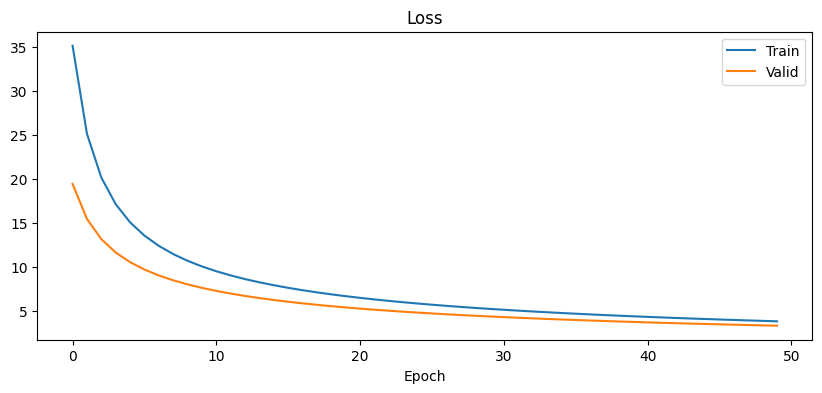

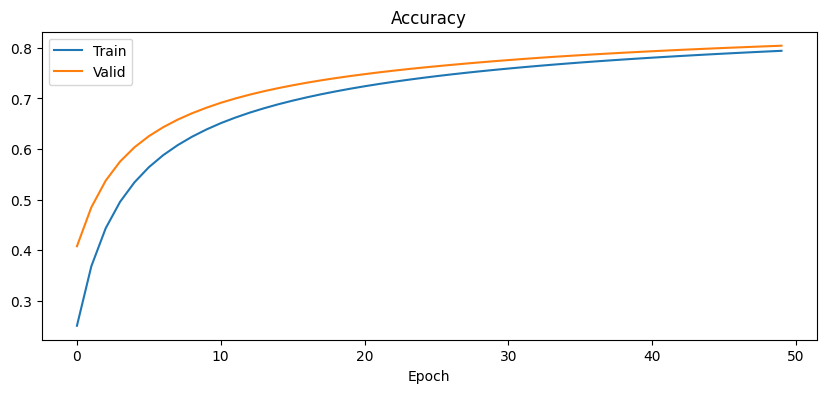

In [14]:
x = range(0, len(epoch_train_loss))
plt.figure(figsize=(10, 4))
plt.title('Loss')
plt.xlabel('Epoch')
plt.plot(x, epoch_train_loss, label="Train")
plt.plot(x, epoch_valid_loss, label="Valid")
plt.legend()
plt.show()

x = range(0, len(epoch_train_acc))
plt.figure(figsize=(10, 4))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(x, epoch_train_acc, label="Train")
plt.plot(x, epoch_valid_acc, label="Valid")
plt.legend()
plt.show()